In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# trip start and end dates
trip_start_date = '2018-06-01'                                               # selected trip start and end dates
trip_end_date = '2018-06-10'

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")
# "sqlite:///Resources/hawaii.sqlite"

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [12]:
precip_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

In [13]:
# load query results in dataframe
precip_df = pd.DataFrame(precip_analysis)  

In [14]:
# converts date to datetime object - Needed to sort the plot properly
precip_df['date'] = pd.to_datetime(precip_df['date'])

# reindexes dataframe by date
precip_df = precip_df.set_index('date')
# renames column for legend
precip_df.rename(columns = {'prcp': 'precipitation'}, inplace=True)
precip_df.head()


,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


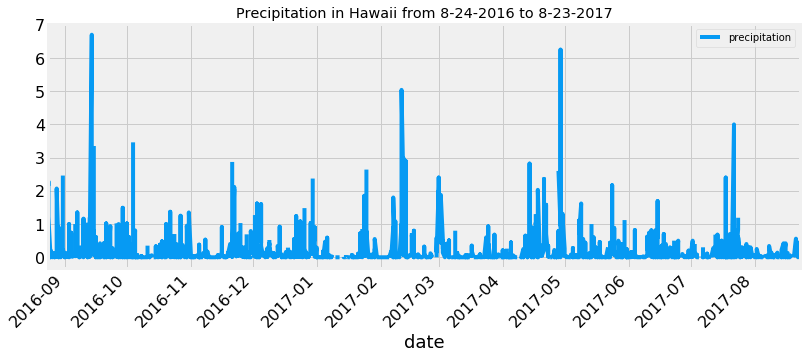

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(12, 5),                                              
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-24-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('date', fontsize=18)
plt.show()


![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# summary stats
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
# count the number of stations then print a statement
station_count = session.query(Station.id).count()   
print(f'There are {station_count} weather stations in Hawaii.')

There are 9 weather stations in Hawaii.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# finds station activity and sorts from most active to least active.
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# displays station activity
station_activity
# displays most active station
station_activity[0] 

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [20]:
for row in reversed(station_activity):                                       # extracts station with most activity
    most_active_station=row.station
    most_active_name=str(row.name)

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station, Measurement.station == Station.station,\
       Measurement.date >="2016-08-24", Measurement.date <="2017-08-23").all()

In [22]:
# extracts temperatures from query
temperatures = [temp[0] for temp in most_active_station_tobs]                


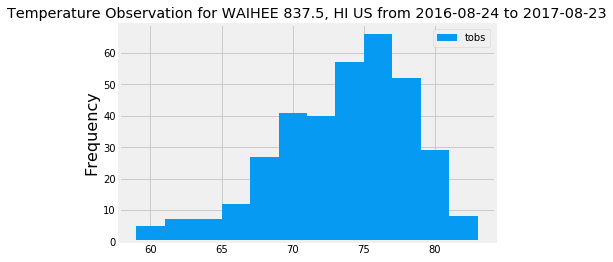

In [23]:
# plots the data
plt.hist(temperatures, bins=12, color='xkcd:azure')             
plt.title("Temperature Observation for %s from 2016-08-24 to 2017-08-23" % (most_active_name))
plt.ylabel('Frequency', fontsize=16)
labels = ['tobs']
plt.legend(labels)
plt.show()

![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start, end):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(np.mean(temperatures))
    temp_list.append(min(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list
#     return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#         filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[69.57142857142857, 62.0, 74.0]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def get_prev_year_date(target):
    try:
        xl = target.split('-')
        xc = (str(int(xl[0])-1)) + '-' + xl[1] + '-' + xl[2]
        return xc
    except:
        return target

In [26]:
# gets previous year start and end dates
start_conv = get_prev_year_date(trip_start_date)
end_conv = get_prev_year_date(trip_end_date)

In [27]:
# calls calc_temps to get plot data
temp_list = calc_temps(start_conv, end_conv)                                 
temp_list

[77.546875, 72.0, 81.0]

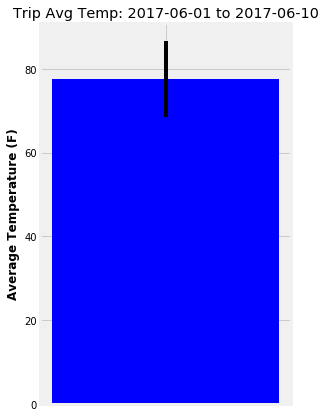

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)       

plt.figure(figsize=(4,7))                                                    # plots data
plt.bar(1, temp_list[0], yerr=(temp_list[2] - temp_list[1]), tick_label='', color='blue')
plt.ylabel("Average Temperature (F)", weight="bold")
plt.title("Trip Avg Temp: %s to %s" % (start_conv, end_conv))
plt.show()

In [35]:

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rainfall = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp).label('precipitation')).\
filter(Measurement.station == Station.station, Measurement.date >= start_conv, Measurement.date <= end_conv).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()


In [36]:
# loads query results into dataframe
rainfall_df = pd.DataFrame(station_rainfall)       


In [37]:
# reindex dataframe by date
rainfall_df = rainfall_df.set_index('precipitation')


In [38]:
# displays dataframe
rainfall_df

,station,name
precipitation,,
0.99,USC00519281,"WAIHEE 837.5, HI US"
0.92,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
0.85,USC00516128,"MANOA LYON ARBO 785.2, HI US"
0.73,USC00513117,"KANEOHE 838.1, HI US"
0.28,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
0.06,USC00519397,"WAIKIKI 717.2, HI US"
NaN,USC00517948,"PEARL CITY, HI US"
